In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python import keras as kt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [17]:
# RNN imports

import keras
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, RNN, SimpleRNN
from keras.utils import to_categorical
from sklearn.manifold import TSNE

In [2]:

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 25, 1000)
Test data shape: (443, 25, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [7]:
# prep datasets for RNN

# fomat data to (batch_size, timesteps, input_dim)
k_X_train = np.swapaxes(X_train_valid, 1, 2)
k_X_test = np.swapaxes(X_test, 1, 2)
print("Swapped axes:",k_X_train.shape, k_X_test.shape)

# remove VOG channels (23-25)
k_X_train = k_X_train[: , : , :22 ]
k_X_test = k_X_test[: , : , :22 ]
print("Removed VOG channels:", k_X_train.shape, k_X_test.shape)

# encode output labels
print("Raw labels:", y_train_valid[0:10])
k_y_train = y_train_valid - 769
k_y_test = y_test - 769
print("Fixed:", k_y_train[0:10])
k_y_train_categ = to_categorical(k_y_train, 4)
k_y_test_categ = to_categorical(k_y_test, 4)
print("Categorical one-hot encoding:\n",k_y_train_categ[0:3])

Swapped axes: (2115, 1000, 25) (443, 1000, 25)
Removed VOG channels: (2115, 1000, 22) (443, 1000, 22)
Raw labels: [771 772 769 769 769 769 771 770 772 772]
Fixed: [2 3 0 0 0 0 2 1 3 3]
Categorical one-hot encoding:
 [[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


In [33]:
# RNN model parameters
k_hidden_size = 200
k_input_shape = k_X_train.shape[1:]

# RNN model
model = Sequential()
model.add(LSTM(k_hidden_size, input_shape=k_input_shape))
model.add(Dense(4, activation='softmax'))

model.summary()
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'],
             )


model.fit(k_X_train, k_y_train_categ, epochs=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               178400    
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 804       
Total params: 179,204
Trainable params: 179,204
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2115/2115 [==============================] - 113s 54ms/step - loss: 1.4528 - acc: 0.2459
Epoch 2/5
2115/2115 [==============================] - 123s 58ms/step - loss: 1.3552 - acc: 0.3395
Epoch 3/5
2115/2115 [==============================] - 131s 62ms/step - loss: 1.2943 - acc: 0.4028
Epoch 4/5
2115/2115 [==============================] - 135s 64ms/step - loss: 1.2510 - acc: 0.4416
Epoch 5/5
2115/2115 [==============================] - 121s 57ms/step - loss: 1.1916 - acc: 0.4827


In [34]:
layer_name = 'dense_6'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(k_X_train)

In [35]:
X_embedded = TSNE(n_components=2, verbose=1).fit_transform(intermediate_output)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2115 samples in 0.002s...
[t-SNE] Computed neighbors for 2115 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2115
[t-SNE] Computed conditional probabilities for sample 2000 / 2115
[t-SNE] Computed conditional probabilities for sample 2115 / 2115
[t-SNE] Mean sigma: 0.038673
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.782127
[t-SNE] KL divergence after 1000 iterations: 0.924009


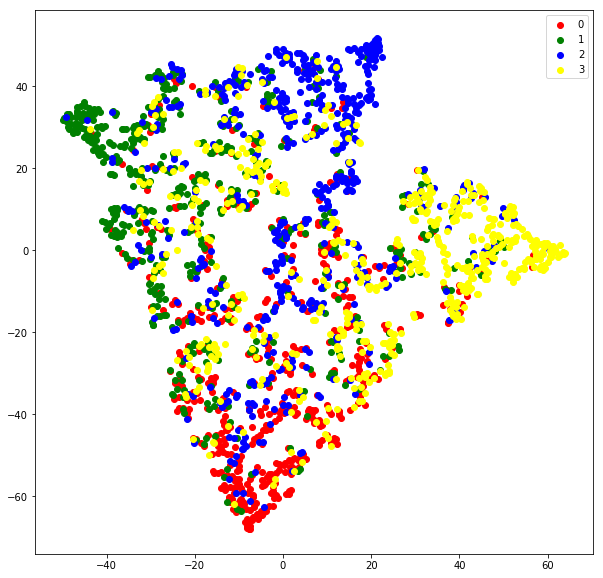

In [36]:
target_ids = [0, 1, 2, 3]
colors = ['red', 'green', 'blue', 'yellow']
labels = list(map(str, target_ids))

fig = plt.figure(figsize=(10, 10))
for i, c, label in zip(target_ids, colors, labels):
    plt.scatter(X_embedded[k_y_train== i, 0], X_embedded[k_y_train== i, 1], c=c, label=label)

plt.legend()
    
plt.show()

In [24]:
# evaluate
model.evaluate(k_X_test, k_y_test_categ)

443/443 [==============================] - 1s 2ms/step


[1.4865885582788265, 0.23024830625773016]